In [1]:
PFSSPEC_ROOT = '/home/swei20/project/pfs_spec_dnn'
PFSSPEC_DATA = '/scratch/ceph/dobos/data/pfsspec'
GRID_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/grid/bosz_50000_2/'

In [2]:
import os, sys, warnings

# Allow load project as module
sys.path.insert(0, PFSSPEC_ROOT)

# Set environment
os.environ['PFSSPEC_ROOT'] = PFSSPEC_ROOT
os.environ['PFSSPEC_DATA'] = PFSSPEC_DATA
os.environ['PYSYN_CDBS'] = os.path.join(os.environ['PFSSPEC_DATA'], 'cdbs')

# Filter warnings
warnings.filterwarnings("ignore")

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import os
import getpass
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from scipy.optimize import curve_fit
from scipy import ndimage
from scipy.ndimage.filters import maximum_filter1d
from scipy.interpolate import Rbf, interp1d, interpn

from pfsspec.physics import Physics

from pfsspec.stellarmod.alexcontinuummodel import AlexContinuumModel

In [102]:
%load_ext autoreload
%autoreload 2

In [103]:
from pfsspec.stellarmod.alexcontinuummodel import AlexContinuumModel, AlexContinuumModelTrace
from viska.plot_laszlo import *

# Load grid

In [5]:
from pfsspec.data.arraygrid import ArrayGrid
from pfsspec.stellarmod.modelgrid import ModelGrid
from pfsspec.stellarmod.bosz import Bosz

In [6]:
fn = os.path.join(os.environ['PFSSPEC_DATA'], GRID_PATH, 'spectra.h5')

In [7]:
grid = ModelGrid(Bosz(), ArrayGrid)
grid.preload_arrays = False
grid.load(fn, format='h5')

In [8]:
for k in grid.grid.axes:
    print(k, grid.grid.axes[k].values)

Fe_H [-2.5  -2.25 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25
  0.5   0.75]
T_eff [ 3500.  3750.  4000.  4250.  4500.  4750.  5000.  5250.  5500.  5750.
  6000.  6250.  6500.  6750.  7000.  7250.  7500.  7750.  8000.  8250.
  8500.  8750.  9000.  9250.  9500.  9750. 10000. 10250. 10500. 10750.
 11000. 11250. 11500. 11750. 12000. 12500. 13000. 13500. 14000. 14500.
 15000. 15500. 16000. 16500. 17000. 17500. 18000. 18500. 19000. 19500.
 20000. 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000.
 30000. 31000. 32000. 33000. 34000. 35000.]
log_g [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
C_M [-0.75 -0.5  -0.25  0.    0.25  0.5 ]
O_M [-0.25  0.    0.25  0.5 ]


In [9]:
for k in grid.grid.values:
    print(k, grid.grid.value_shapes[k])

flux (216906,)
cont (216906,)
params None


# Pick a spectrum and fit with model

In [65]:
Fe_H = 0.0
T_eff = 8000
log_g = 5

In [66]:
spec = grid.get_nearest_model(Fe_H=Fe_H, T_eff=T_eff, log_g=log_g, O_M=0, C_M=0)

In [67]:
model = AlexContinuumModel()
model.init_wave(spec.wave)

params = model.fit(spec)
params.shape

(36,)

In [68]:
#cont = model.eval_continuum(params)
wave, cont = model.eval(params)

In [126]:
plt.style.use('ieee')
# plt.style.use('default')

In [134]:
r_pix = 6
c_pix = 2.4

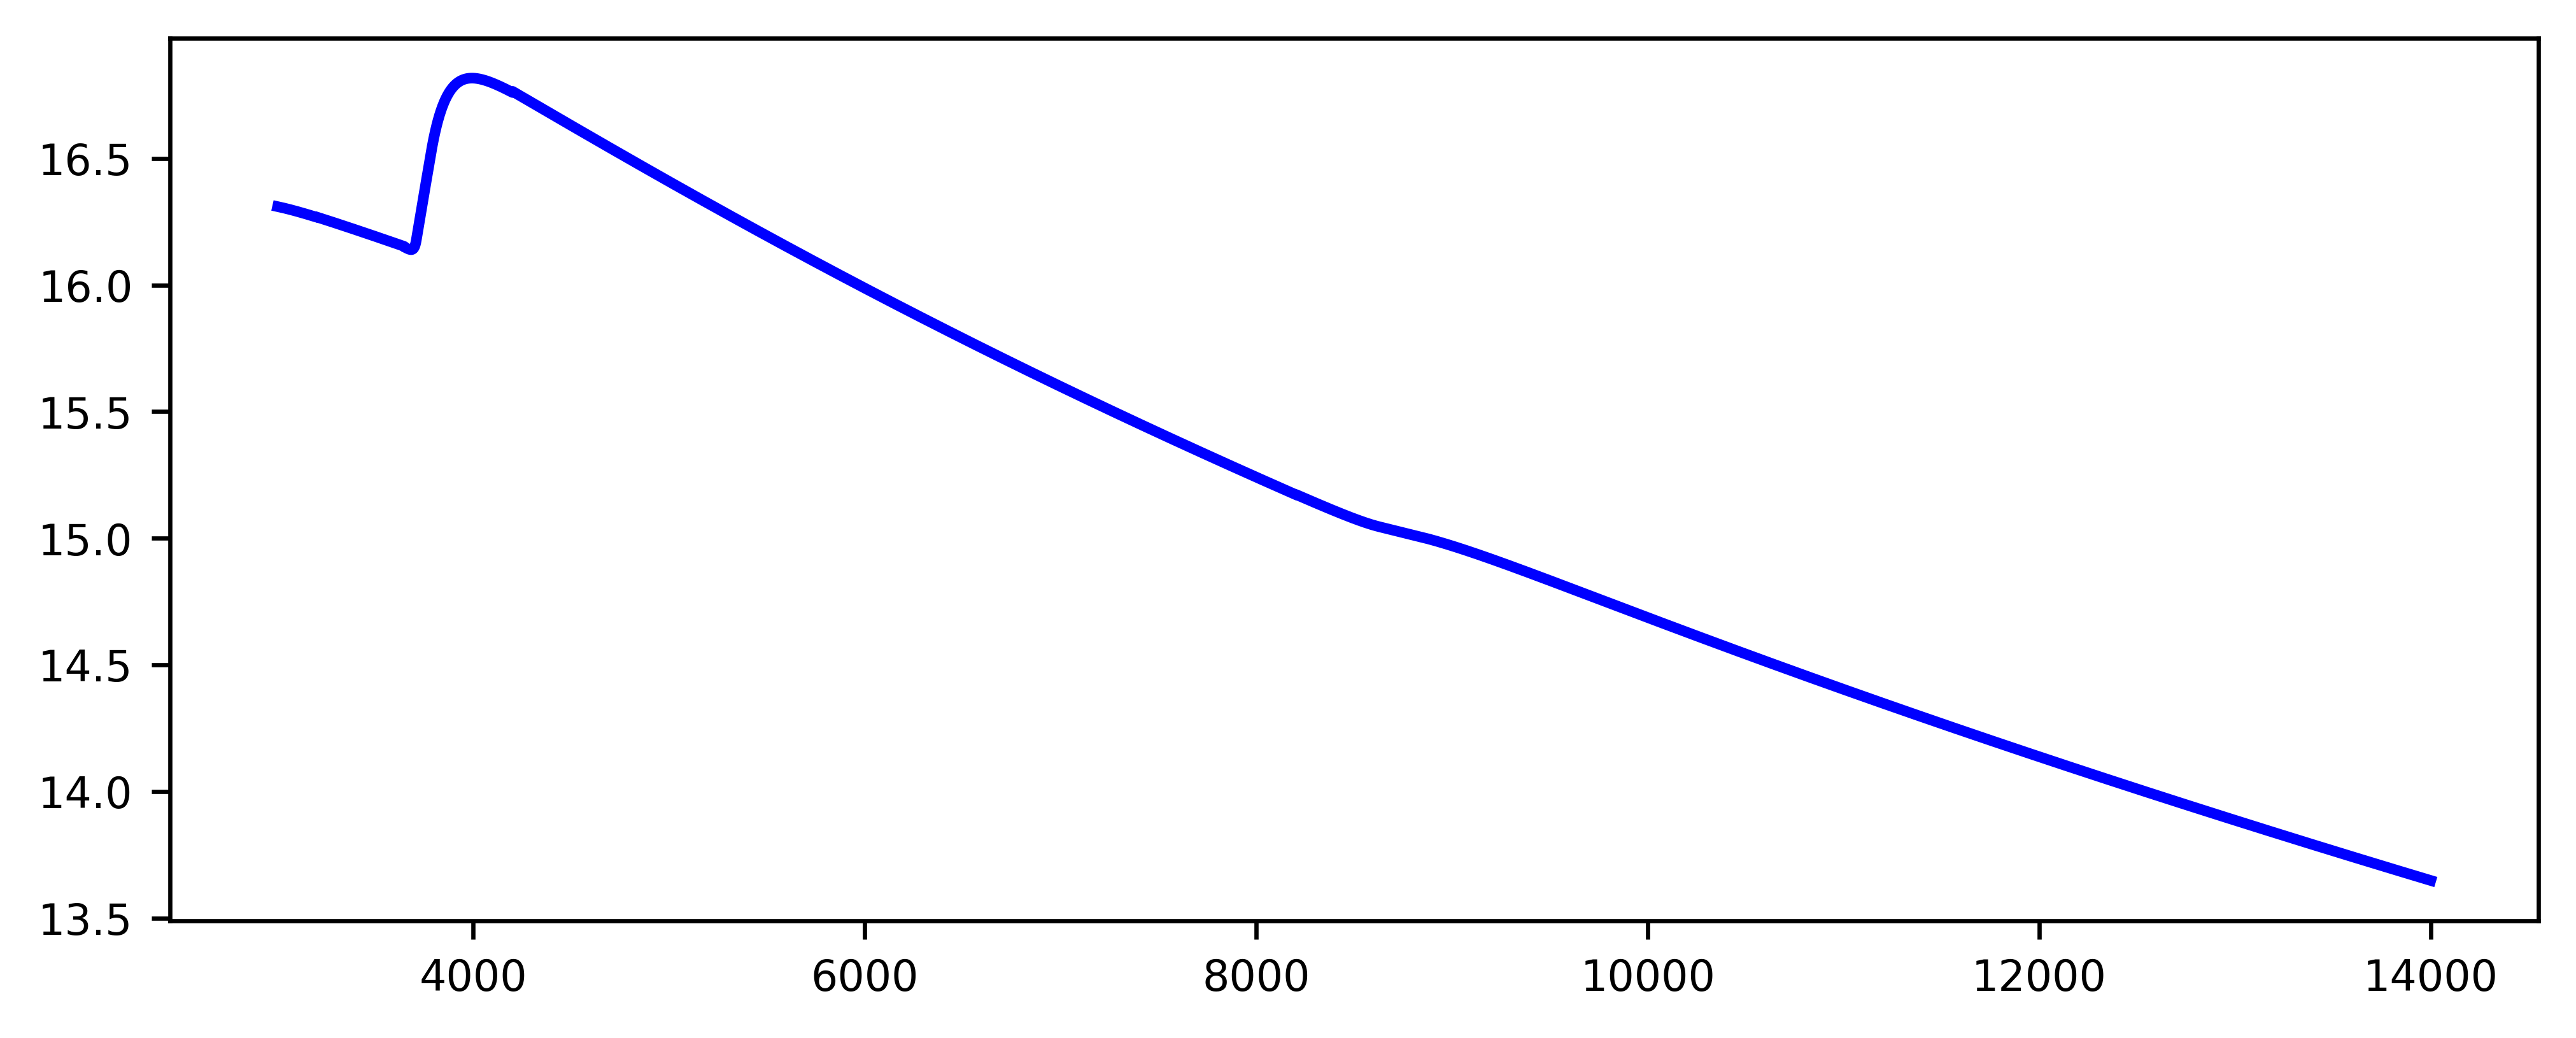

In [128]:
f, ax = plt.subplots(1, figsize = (r_pix, c_pix))

ax.plot(wave, cont, lw=2, c='b', label = '$ln(cont)$')


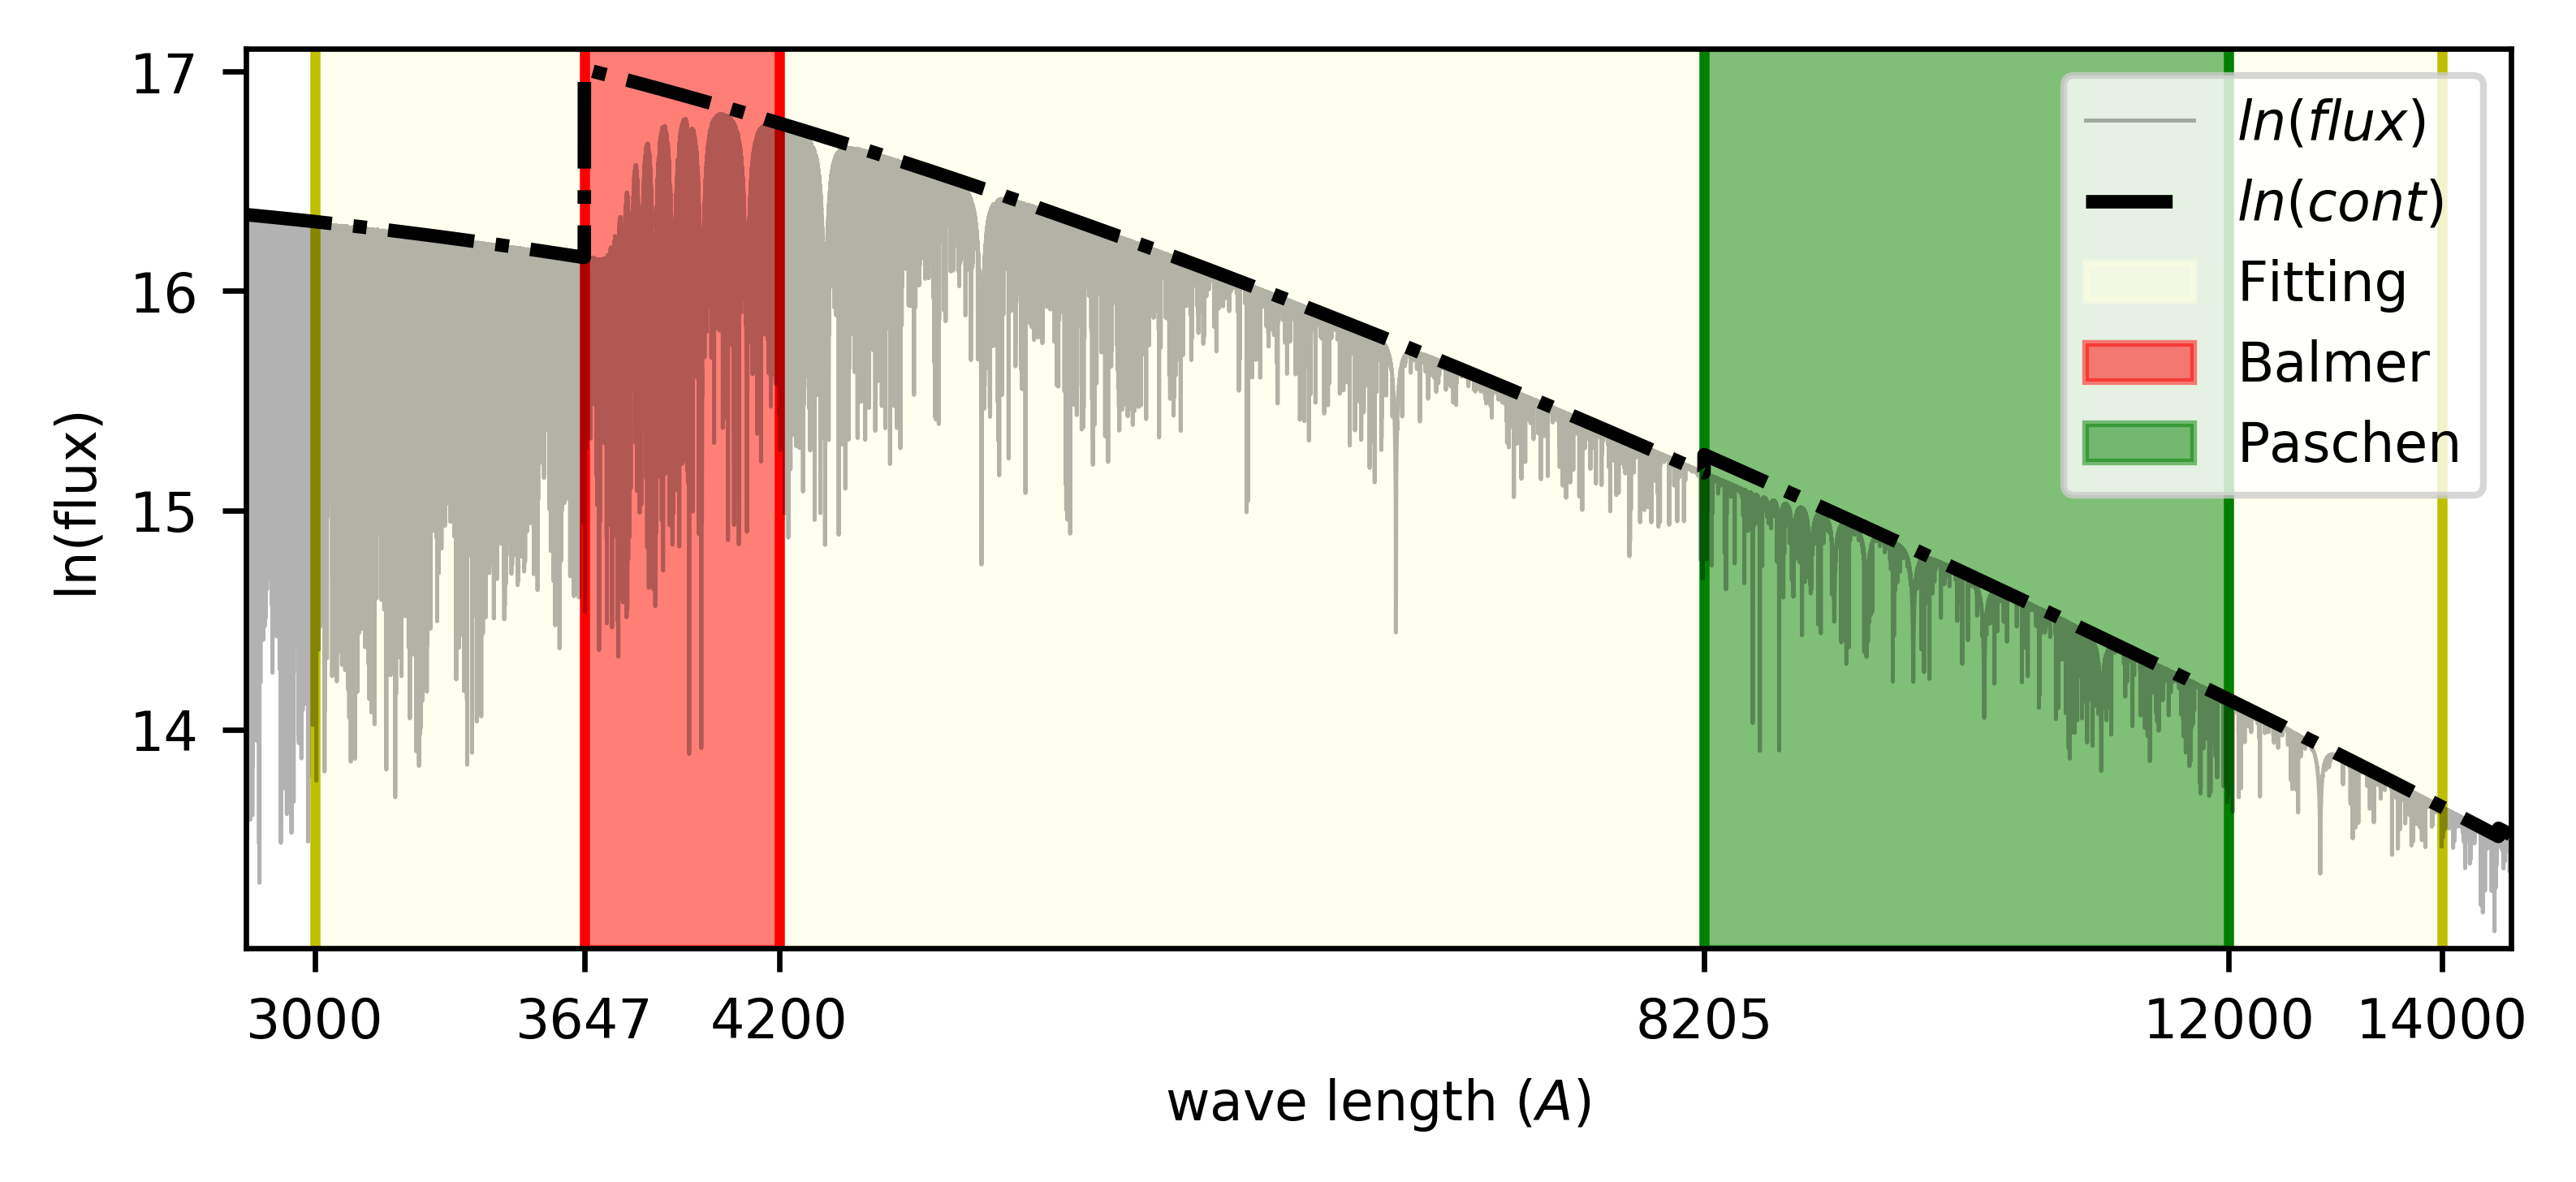

In [135]:
f, ax = plt.subplots(1, figsize = (r_pix, c_pix))
# f, ax = plt.subplots(1) 
ax.plot(np.log(spec.wave), np.log(spec.flux), lw=0.6, c='k', alpha = 0.3, label = '$ln(flux)$')
ax.plot(np.log(spec.wave), np.log(spec.cont), 'k-.', lw=2,  label = '$ln(cont)$')
# ax.plot(np.log(wave), cont, lw=2, c='b', label = '$Legendre$')

yy = np.log(spec.flux)
plot_seg(yy, ax = ax)

Text(0.5, 0.98, 'Fitting continuum with Legendre Polynomial')

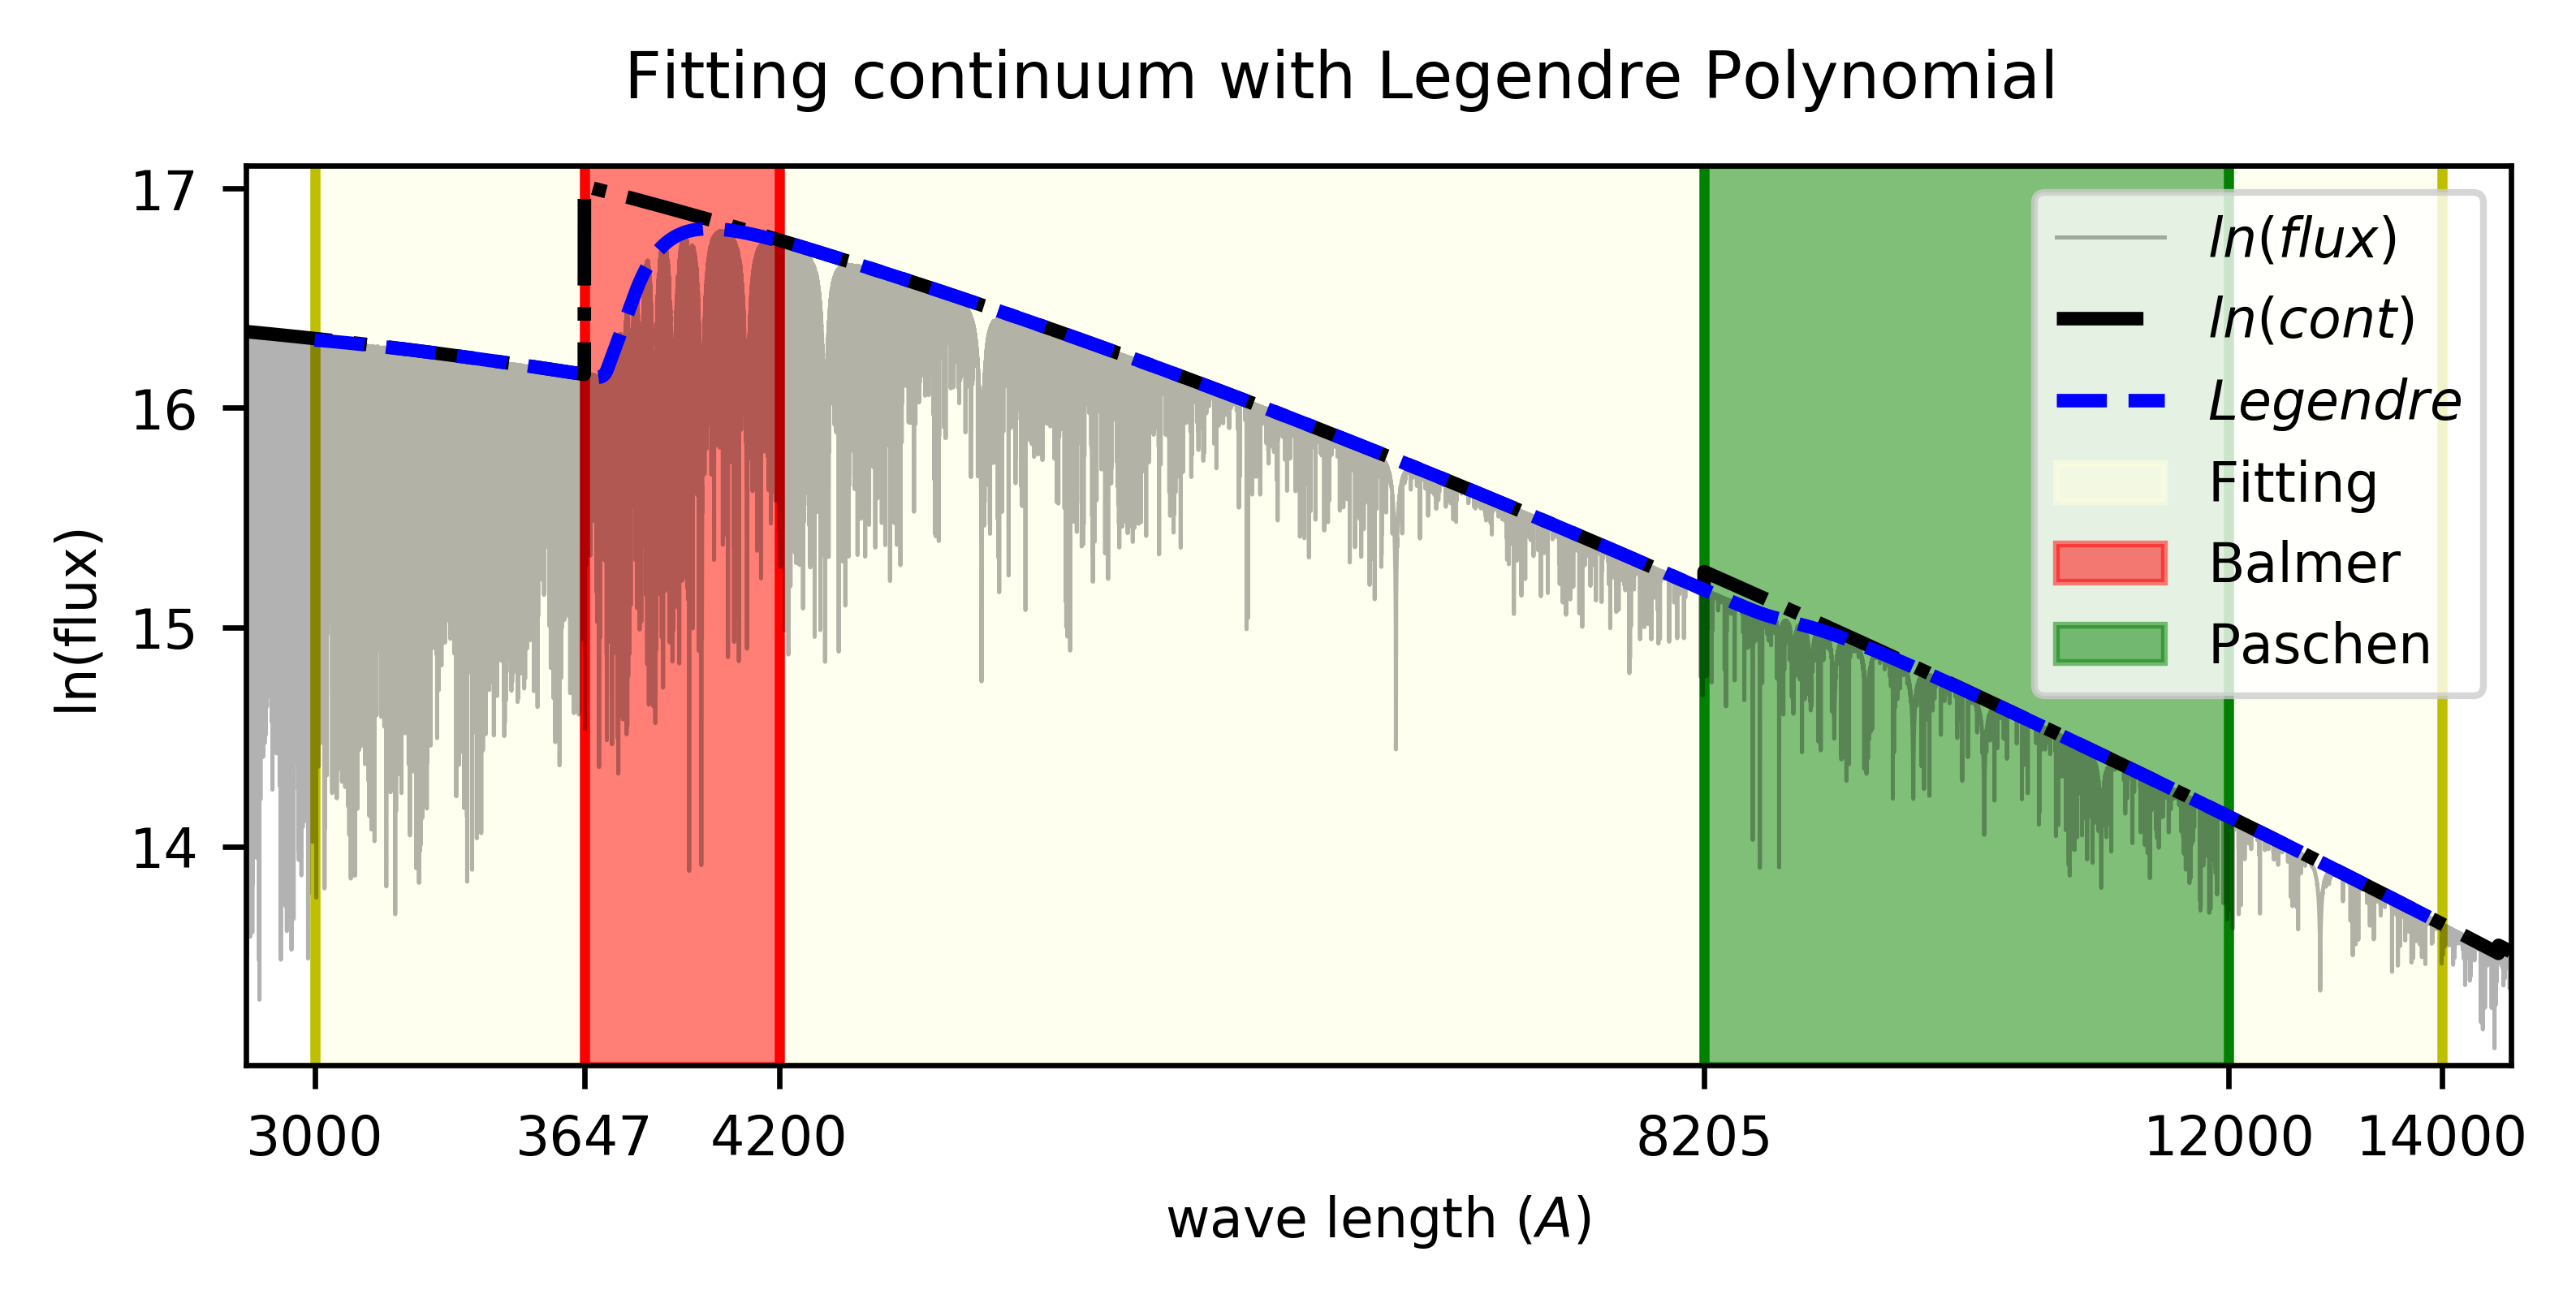

In [137]:
f, ax = plt.subplots(1, figsize = (r_pix, c_pix))
# f, ax = plt.subplots(1) 

ax.plot(np.log(spec.wave), np.log(spec.flux), lw=0.6, c='k', alpha = 0.3, label = '$ln(flux)$')

# ax.plot(np.log(spec.wave), np.log(spec.cont), 'k-.', lw=2,  label = '$ln(cont)$')

yy = np.log(spec.flux)
plot_seg(yy, ax = ax, legend=0)

ax.plot(np.log(wave), cont, lw=2, c='b', label = '$Legendre$')
ax.legend()
# f.suptitle('Fitting continuum with Legendre Polynomial')

In [138]:
spec = grid.get_nearest_model(Fe_H=Fe_H, T_eff=T_eff, log_g=log_g, O_M=0, C_M=0)
trace = AlexContinuumModelTrace()
self = AlexContinuumModel(trace=trace)  
self.init_wave(spec.wave)

In [139]:
params = self.fit(spec)  
self.normalize(spec, params)

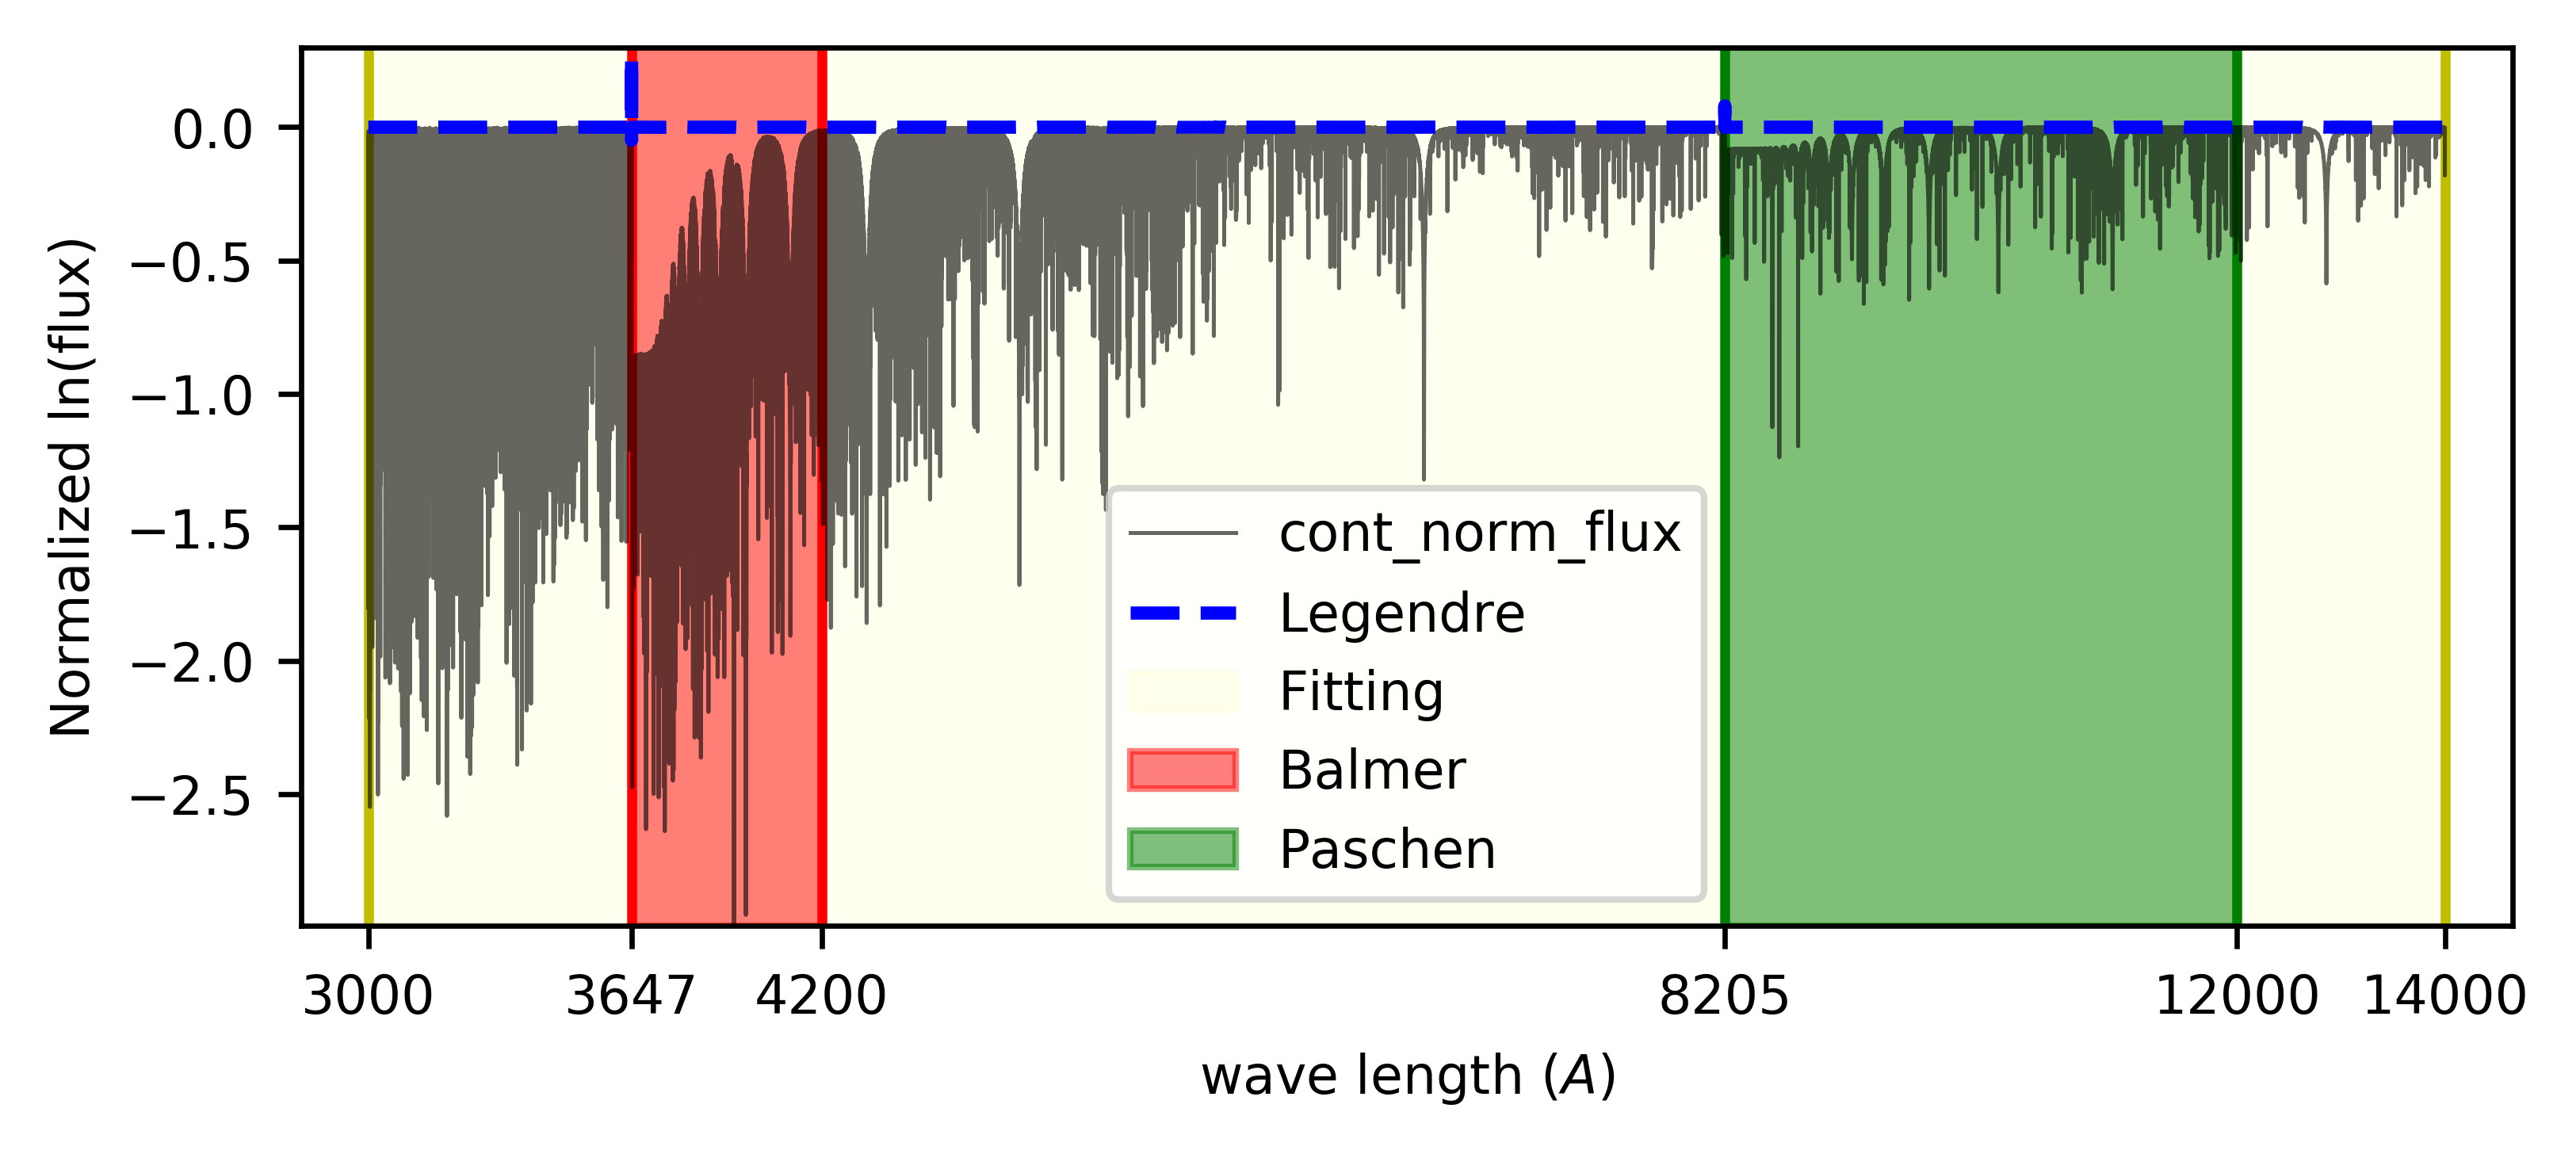

In [151]:
f, ax = plt.subplots(1, figsize = (r_pix, c_pix))
ax.plot(self.log_wave, self.trace.cont_norm_flux, 'k', lw = 0.6, alpha = 0.6, label='cont_norm_flux')
ax.plot(self.log_wave, self.trace.norm_cont, 'b', lw = 2, alpha = 1, label='Legendre')

# yy = np.log(spec.flux)
plot_seg(self.trace.cont_norm_flux, ax = ax, legend=0, ymin_mode = 1)

# ax.plot(np.log(wave), cont, lw=2, c='b', label = '$Legendre$')
ax.legend()
# f.suptitle('Fitting Hydrogen limits with Sigmoid-Shaped Function')

ValueError: operands could not be broadcast together with shapes (216906,) (154044,) 

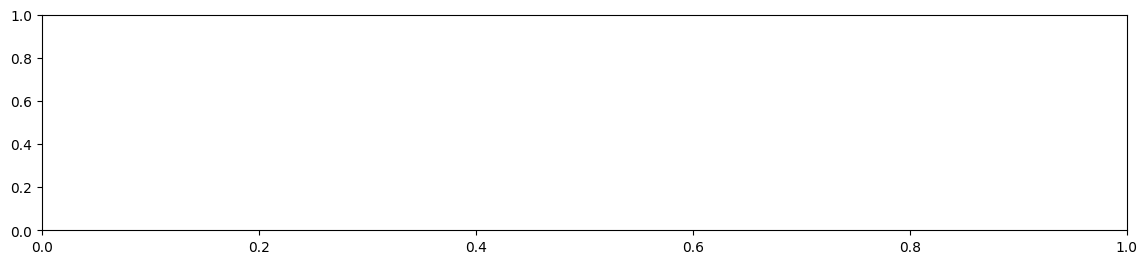

In [125]:
f, ax = plt.subplots(1, figsize = (r_pix, c_pix))
# f, ax = plt.subplots(1) 

ax.plot(np.log(wave), np.log(flux / cont))

# ax.plot(np.log(spec.wave), np.log(spec.flux/spec.cont), lw=0.6, c='k', alpha = 0.3, label = '$ln(flux)$')
# ax.plot(np.log(spec.wave), np.log(spec.cont), 'k-.', lw=2,  label = '$ln(cont)$')

# yy = np.log(spec.flux)
# plot_seg(yy, ax = ax, legend=0)

ax.plot(np.log(wave), cont, lw=2, c='b', label = '$Legendre$')
ax.legend()
f.suptitle('Fitting continuum with Legendre Polynomial')

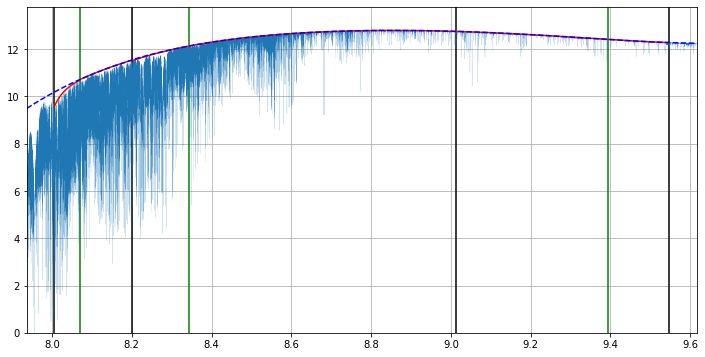

In [14]:
plt.figure(figsize=(12, 6))

plt.axvline(np.log(3000), c='k')
plt.axvline(np.log(3647.04864611), c='k')
plt.axvline(np.log(8205.95948252), c='k')
plt.axvline(np.log(14000), c='k')

plt.axvline(np.log(3200), c='green')
plt.axvline(np.log(4200), c='green')
plt.axvline(np.log(12000), c='green')

plt.plot(np.log(spec.wave), np.log(spec.flux), lw=0.1)
plt.plot(np.log(wave), cont, c='r')
plt.plot(np.log(spec.wave), np.log(spec.cont), 'b--')

plt.xlim(np.log(2800), np.log(15000))
plt.ylim(0, None)
plt.grid(True)

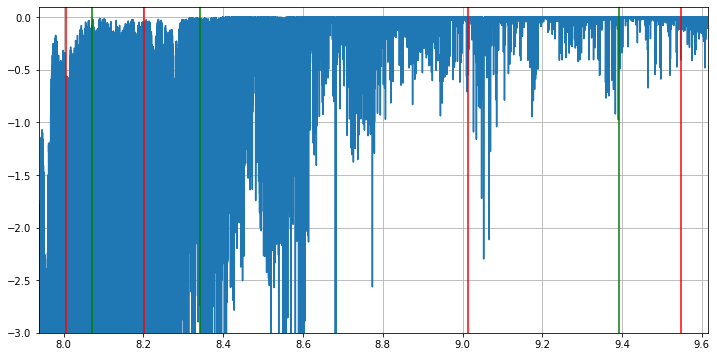

In [42]:
plt.figure(figsize=(12, 6))

plt.plot(np.log(spec.wave), np.log(spec.flux / spec.cont))

plt.axvline(np.log(3000), c='red')
plt.axvline(np.log(3647.04864611), c='red')
plt.axvline(np.log( 8205.95948252), c='red')
plt.axvline(np.log(14000), c='red')

plt.axvline(np.log(3200), c='green')
plt.axvline(np.log(4200), c='green')
plt.axvline(np.log(12000), c='green')

plt.xlim(np.log(2800), np.log(15000))
plt.ylim(-3, 0.1)
plt.grid(True)